# Google Colab Lab Assignment -Pretrained Model

**Course Name:** Deep Learning

**Lab Title:** Research Paper Implementation with Pre-trained Model (Deep Convolutional Neural Networks for breast cancer screening)

**Student Name:** Pranav Khatavkar

**Student ID:** 202201090028

**Date of Submission:** 21/02/2025

**Group Members**: Aditya Sawleshwarkar,
                   Omkar Karlekar

**Research Paper Study and Implementation**

**Instructions:**

1. Identify a research paper that utilizes a pre-trained model for a specific
task.

2. Study the methodology, dataset, and model used in the research paper.

3. Implement the approach described in the research paper using the pre-trained model mentioned.

4. Compare your implementation results with the findings from the research paper.


**Objective**
1.   Study a research paper utilizing a pre-trained model.
2.   Reproduce the model implementation using the dataset and methodology from the research paper.
3.   Fine-tune the pre-trained model and optimize hyperparameters.
3.   Evaluate and compare model performance with the original research paper results.









**Task 1: Research Paper Selection and Dataset Preparation (2 hours)**

**Instructions:**

1. Select a research paper that applies a pre-trained model (e.g., VGG, ResNet, EfficientNet, etc.).

2. Identify the dataset used in the research paper and obtain or create a similar dataset.(**Mention Dataset Link and Description**)

3. Perform necessary preprocessing steps:

 Resize images to match the model input dimensions.

 Apply data augmentation techniques if applicable.

4. Split the dataset into training, validation, and testing sets.

In [1]:
# Research paper link : https://drive.google.com/file/d/1iU9C77WVK4Y-eEQ43mfe9EC_1DNynqbL/view?usp=sharing
# Dataset Link : https://www.kaggle.com/datasets/mdkhurshidjahan01/mamography/data
# Description: This CBIS-DDSM (Curated Breast Imaging Subset of DDSM) is an updated and standardized version of the Digital Database for Screening Mammography (DDSM).
#This dataset has 10.4k images of cancer and non cancer labelled cases. The dataset is already augmented.

#Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "pranavkhatavkar" # username from the json file
os.environ['KAGGLE_KEY'] = "0d8b0ed57f60c8a5fb6757b636b1f37f" # key from the json file

!kaggle datasets download -d mdkhurshidjahan01/mamography

Dataset URL: https://www.kaggle.com/datasets/mdkhurshidjahan01/mamography
License(s): unknown
100% 934M/934M [00:36<00:00, 33.1MB/s]
100% 934M/934M [00:36<00:00, 27.1MB/s]


In [2]:
!unzip mamography.zip

Streaming output truncated to the last 5000 lines.
  inflating: Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Augmented Dataset/Non-Cancer/IMG (362)_PiecewiseAffine.jpg  
  inflating: Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Augmented Dataset/Non-Cancer/IMG (362)_Resize.jpg  
  inflating: Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Augmented Dataset/Non-Cancer/IMG (362)_Rotate.jpg  
  inflating: Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Augmented Dataset/Non-Cancer/IMG (363).jpg  
  inflating: Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Augmented Dataset/Non-Cancer/IMG (363)_AdditiveGaussianNoise.jpg  
  inflating: Mammogram Mastery A Robust Dataset for Breast Cancer Detect

In [3]:
dataset_path = "/content/Mammogram Mastery A Robust Dataset for Breast Cancer Detection and Medical Education/Breast Cancer Dataset/Augmented Dataset"

# List class folders
class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Classes:", class_dirs)


Classes: ['Non-Cancer', 'Cancer']


<ipython-input-5-606e841a63fa>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Class"], y=df["Count"], palette="viridis")


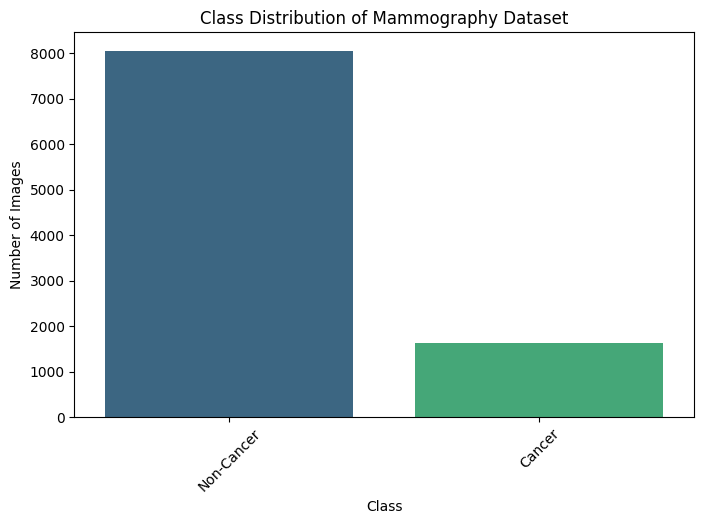

In [5]:
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_dirs}
df = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])

plt.figure(figsize=(8, 5))
sns.barplot(x=df["Class"], y=df["Count"], palette="viridis")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Mammography Dataset")
plt.xticks(rotation=45)
plt.show()


In [6]:
from tensorflow.keras.applications.inception_v3 import preprocess_input  # Works for InceptionV4
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

IMG_SIZE = 299  # Required by InceptionV4

def preprocess_image(img_path):
    """Load and preprocess an image for InceptionV4."""
    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))  # Resize
    image = img_to_array(image)  # Convert to array
    image = preprocess_input(image)  # Apply InceptionV4 preprocessing
    return image


In [7]:
from sklearn.model_selection import train_test_split
import shutil

# Define base directories
base_dir = "/content/mamography_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create directories
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Define split ratios
split_ratios = (0.7, 0.15, 0.15)  # 70% train, 15% val, 15% test

# Dictionary to store split counts
split_counts = {"train": {}, "val": {}, "test": {}}

for cls in class_dirs:
    cls_path = os.path.join(dataset_path, cls)
    images = os.listdir(cls_path)

    train_imgs, test_val_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(test_val_imgs, test_size=0.5, random_state=42)

    # Store image counts
    split_counts["train"][cls] = len(train_imgs)
    split_counts["val"][cls] = len(val_imgs)
    split_counts["test"][cls] = len(test_imgs)

    # Copy images to respective directories
    for img_set, subdir in zip([train_imgs, val_imgs, test_imgs], [train_dir, val_dir, test_dir]):
        cls_subdir = os.path.join(subdir, cls)
        os.makedirs(cls_subdir, exist_ok=True)

        for img in img_set:
            src_path = os.path.join(cls_path, img)
            dst_path = os.path.join(cls_subdir, img)
            shutil.copy(src_path, dst_path)

# Print dataset split details
print("\nDataset successfully split into train, val, and test directories!\n")
for split, counts in split_counts.items():
    print(f" {split.upper()} SET:")
    for cls, count in counts.items():
        print(f"   {cls}: {count} images")
    print()



Dataset successfully split into train, val, and test directories!

 TRAIN SET:
   Non-Cancer: 5642 images
   Cancer: 1137 images

 VAL SET:
   Non-Cancer: 1209 images
   Cancer: 244 images

 TEST SET:
   Non-Cancer: 1209 images
   Cancer: 244 images



In [8]:
batch_size = 16

# Define ImageDataGenerator with preprocessing function
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.15  # 15% validation split
)

# Define dataset directories
train_dir = "/content/mamography_split/train"
val_dir = "/content/mamography_split/val"
test_dir = "/content/mamography_split/test"

# Load train dataset
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',  # or 'categorical' if more than 2 classes
    subset='training'
)

# Load validation dataset
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Load test dataset (No shuffling for evaluation)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Preprocessing completed. Ready for training!")


Found 5763 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Found 1453 images belonging to 2 classes.
Preprocessing completed. Ready for training!


**Task 2: Model Implementation and Fine-tuning**

**Instructions:**

1. Implement the pre-trained model as described in the research paper.

2. Visualize feature maps of few layers

3. Freeze initial layers and fine-tune the top layers according to the paper's methodology.

4. Optimize hyperparameters such as:

  Learning rate

  Batch size

  Number of epochs

  Optimizer choice (Adam, SGD, RMSprop, etc.)

4. Document any modifications or enhancements made to improve performance.

In [15]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Function to create a fresh model
def create_model():
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation="sigmoid")(x)

    return Model(inputs=base_model.input, outputs=output_layer)

# Define optimizers
optimizers = {
    "Adam": Adam(learning_rate=1e-4),
    "SGD": SGD(learning_rate=1e-4, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=1e-4)
}

histories = {}  # Dictionary to store training histories

for opt_name, optimizer in optimizers.items():
    print(f"\n🔹 Training with {opt_name} optimizer...\n")

    # Create a fresh model instance
    model = create_model()

    # Compile model with the current optimizer
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=100,  # Reduce from 181
    validation_steps=20
    )

    # Store the training history
    histories[opt_name] = history



🔹 Training with Adam optimizer...

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1506s 14s/step - accuracy: 0.8431 - loss: 0.3430 - val_accuracy: 0.9309 - val_loss: 0.1691
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1477s 15s/step - accuracy: 0.9544 - loss: 0.1419 - val_accuracy: 0.9493 - val_loss: 0.1277
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1445s 14s/step - accuracy: 0.9824 - loss: 0.0691 - val_accuracy: 0.9770 - val_loss: 0.0749
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 931s 9s/step - accuracy: 0.9734 - loss: 0.0928 - val_accuracy: 0.9677 - val_loss: 0.0719
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1501s 14s/step - accuracy: 0.9825 - loss: 0.0552 - val_accuracy: 0.9724 - val_loss: 0.0818

🔹 Training with SGD optimizer...

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1459s 14s/step - accuracy: 0.6711 - loss: 0.5863 - val_accuracy: 0.8341 - val_loss: 0.3822
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1396s 14s/step - accuracy: 0.8379 - loss: 0.3879 - val_accuracy: 0.8341 - val_loss: 0.3237
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1403s 14s/step - accuracy: 0.8753 - loss: 0.3073 - val_accuracy: 0.8848 - val_loss: 0.2486
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 874s 9s/step - accuracy: 0.9

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


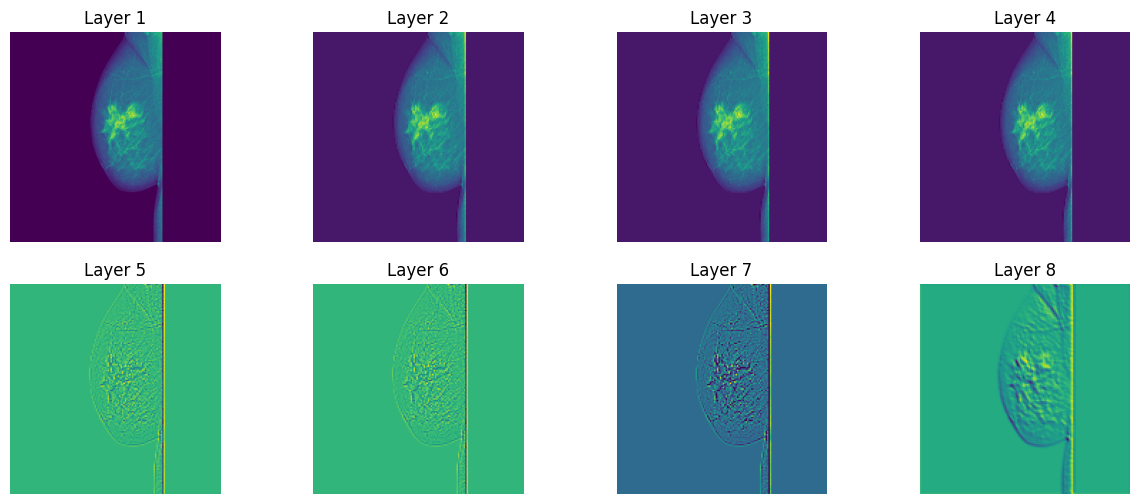

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img_path = "/content/mamography_split/train/Cancer/IMG (1).jpg"  # Replace with an actual image path
img = load_img(img_path, target_size=(299, 299))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Convert to batch format
img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

# Select a few layers to visualize
layer_outputs = [layer.output for layer in base_model.layers[:8]]  # First 8 layers
feature_map_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Get feature maps
feature_maps = feature_map_model.predict(img_array)

# Plot feature maps
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
axes = axes.flatten()

for i in range(8):
    axes[i].imshow(feature_maps[i][0, :, :, 0], cmap="viridis")
    axes[i].axis("off")
    axes[i].set_title(f"Layer {i+1}")

plt.show()


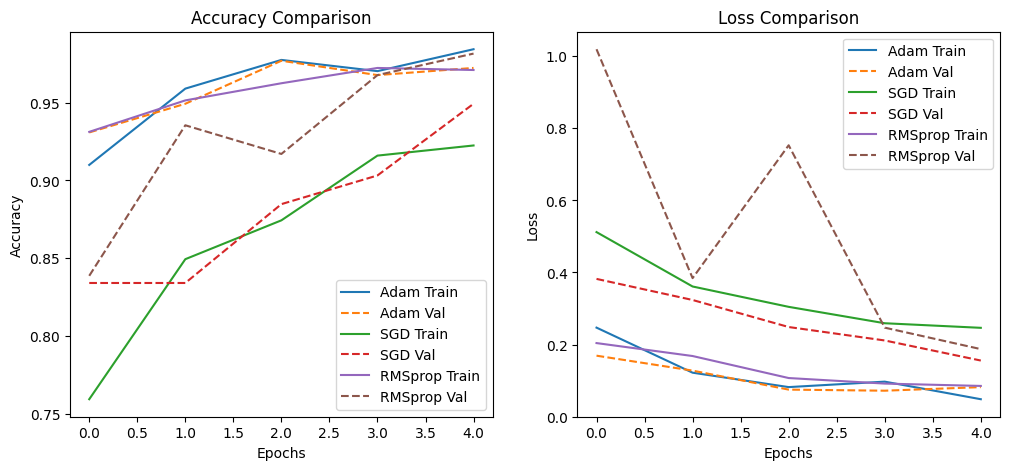

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 🔹 Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
for opt_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f"{opt_name} Train")
    plt.plot(history.history['val_accuracy'], linestyle="dashed", label=f"{opt_name} Val")

plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 🔹 Plot Training & Validation Loss
plt.subplot(1, 2, 2)
for opt_name, history in histories.items():
    plt.plot(history.history['loss'], label=f"{opt_name} Train")
    plt.plot(history.history['val_loss'], linestyle="dashed", label=f"{opt_name} Val")

plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


**Task 3: Model Evaluation and Performance Comparison**

**Instructions:**

1. Evaluate the trained model using performance metrics:

 Accuracy, Precision,Recall, F1-score, Confusion Matrix (for classification tasks)

2. Compare the results with those reported in the research paper.

3. Identify potential weaknesses and suggest improvements.
**Deliverables:**

Performance metrics summary (table or chart).

Graphs/plots showcasing model accuracy and loss trends.

Comparison with research paper results.

Discussion on model performance and areas for improvement.

In [20]:
# Code for Task 3
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

metrics_results = {}  # Ensure it's initialized outside the loop

for opt_name, optimizer in optimizers.items():
    print(f"\n🔹 Evaluating model trained with {opt_name}...\n")

    # Load trained model for the specific optimizer (if not already available in memory)
   # model = trained_models[opt_name]  # Dictionary storing trained models

    # Evaluate on validation set
    y_true = val_generator.classes  # Actual labels
    y_pred_prob = model.predict(val_generator)  # Predicted probabilities
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Store metrics for this optimizer
    metrics_results[opt_name] = {
        "Accuracy": acc,
        "Precision": pre,
        "Recall": rec,
        "F1-Score": f1
    }

# Print results for all optimizers
for opt_name, metrics in metrics_results.items():
    print(f"\n🔹 Performance for {opt_name} optimizer:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")



🔹 Evaluating model trained with Adam...

14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step

🔹 Evaluating model trained with SGD...

14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step

🔹 Evaluating model trained with RMSprop...

14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step

🔹 Performance for Adam optimizer:
Accuracy: 0.7143
Precision: 0.8251
Recall: 0.8343
F1-Score: 0.8297

🔹 Performance for SGD optimizer:
Accuracy: 0.7604
Precision: 0.8525
Recall: 0.8619
F1-Score: 0.8571

🔹 Performance for RMSprop optimizer:
Accuracy: 0.7512
Precision: 0.8470
Recall: 0.8564
F1-Score: 0.8516


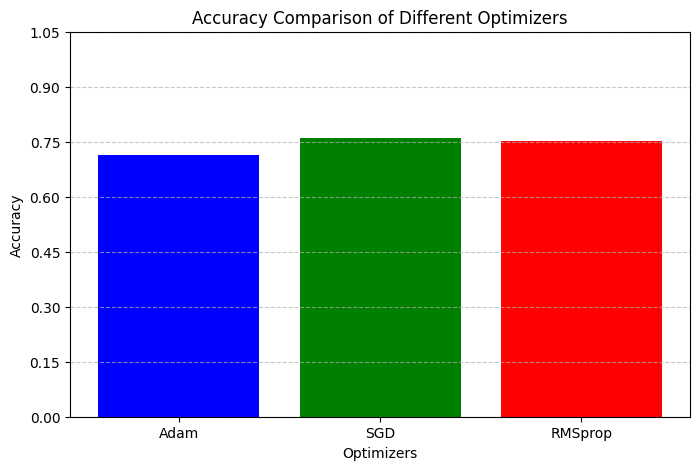

In [26]:

# Extract optimizers and their accuracies
optimizers = list(metrics_results.keys())
accuracies = [metrics_results[opt]["Accuracy"] for opt in optimizers]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(optimizers, accuracies, color=['blue', 'green', 'red'])

# Labels and title
plt.xlabel("Optimizers")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Different Optimizers")

# Increase y-axis ticks
plt.ylim(0, 1)  # Ensure the range is between 0 and 1
plt.yticks(np.arange(0, 1.1, 0.15))  # Increase y-ticks at intervals of 0.05

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()



**Conclusion and Result Visulaization**

Each optimizer was trained on 5 epochs and learning rate of 1e-4

SGD Optimizer obtained the highest test accuracy of 76.04% and ADAM obtained the lowest of 71.43%

The authors of the research paper achieved the highest accuracy of 98.94% on InceptionV3 as base model

The reason for this vast difference is the difference in parameters used for model training. We have used 5 epochs and 100 steps per epoch because of limiting hardware capabilities. It took us 5 hours to complete the model training for all three optimizers.

Below is the accuracy and loss graphs from the research paper followed by our graphs that sow the accuracy and loss comparision for all three optimizers we have used for this project:
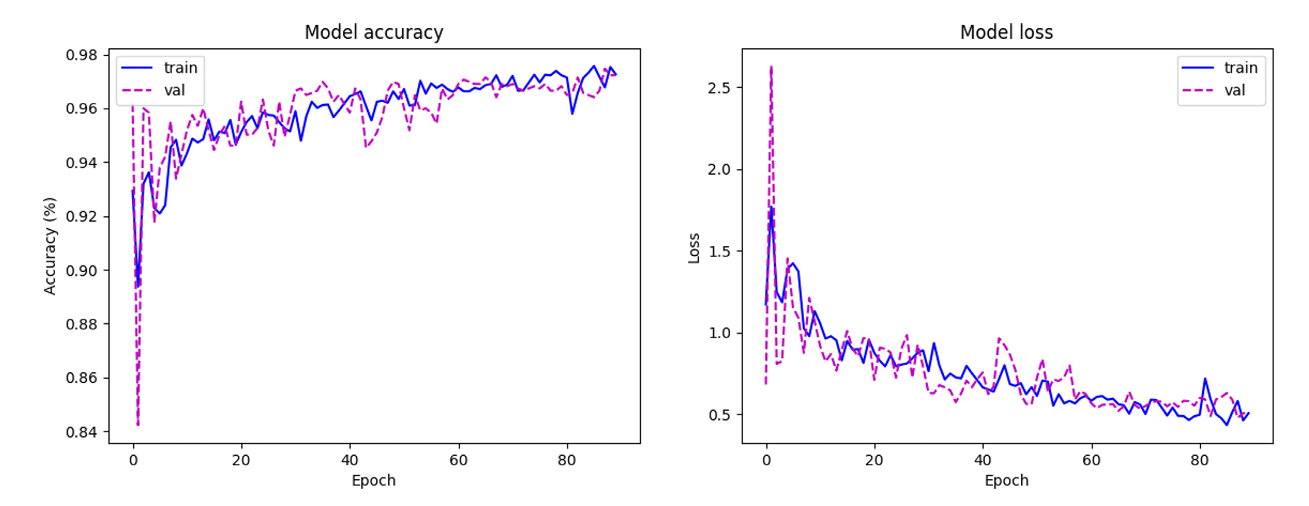


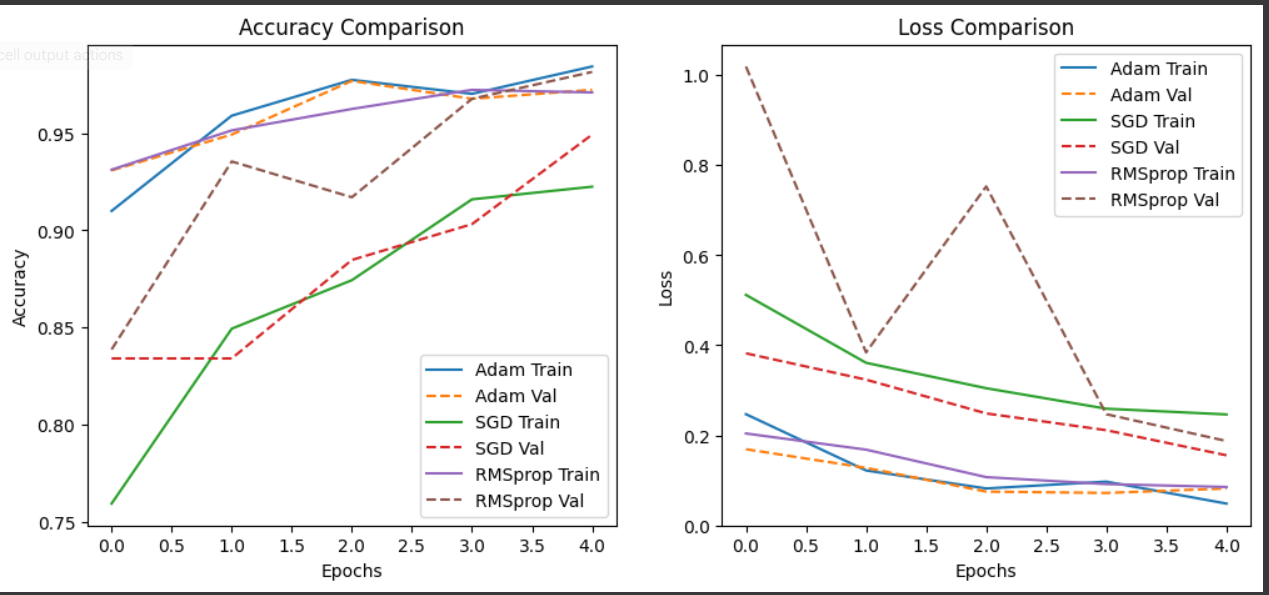



**Declaration**

I, Pranav Khatavkar, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: https://github.com/pranav19611/DL-Lab-Assignments/tree/6274ddcba52d124fb2edd3a70f951b4c24ef429b/DL%20Assignment%202

Signature: Pranav Khatavkar

**Submission Checklist**

✔ Research paper details and summary

✔ Code file (Python Notebook or Script)

✔ Dataset or link to the dataset

✔ Visualizations (if applicable)

✔ Screenshots of model performance metrics

✔ Readme File

✔ Comparison with research paper results